# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
#!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
%config Completer.use_jedi = False

In [4]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment

############### Change file_name argument to your path ########################
env = UnityEnvironment(file_name=r'C:\Users\Ai\Documents\openAI\DeepRL_P2\Reacher_Windows_x86_64\Reacher.exe')
#env = UnityEnvironment(file_name='/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64') # for Linux

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name=r'C:\Users\Ai\Documents\openAI\DeepRL_P2\Reacher_Windows_x86_64_20\Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

In [8]:
#env.close()

### 4. Build an Agent

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device
device = "cpu"

##### 4.1. Policy Network architecture

In [10]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

   
class ActorNN(nn.Module):
    
    def __init__(self, state_size, action_size):
        super(ActorNN, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, action_size)
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x
    
    
class CriticNN(nn.Module):
    
    def __init__(self, state_size):
        super(CriticNN, self).__init__()
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


class PolicyNN(nn.Module):
    
    def __init__(self, state_size, action_size):
        super(PolicyNN, self).__init__()
        self.actor_policy = ActorNN(state_size, action_size)
        self.critic_value = CriticNN(state_size)
        # for action sampling in buffer and action log probability calculation
        self.std = nn.Parameter(torch.ones(1, action_size))
        self.to(device)

    def forward(self, states, action=None):
        states = torch.Tensor(states)
        a = self.actor_policy(states)
        v = self.critic_value(states)
        
        dist = torch.distributions.Normal(a, self.std)
        if action is None: # action sampling
            action = dist.sample()
        log_prob = dist.log_prob(action)
        log_prob = torch.sum(log_prob, dim=1, keepdim=True)
        return action, log_prob, v

##### 4.2. Helper object for batch optimization

In [11]:



class Batcher:
    
    def __init__(self, batch_size, data):
        self.batch_size = batch_size
        self.data = data
        self.num_entries = len(data[0])
        self.reset()

    def reset(self):
        self.batch_start = 0
        self.batch_end = self.batch_start + self.batch_size

    def end(self):
        return self.batch_start >= self.num_entries

    def next_batch(self):
        batch = []
        for d in self.data:
            batch.append(d[self.batch_start: self.batch_end])
        self.batch_start = self.batch_end
        self.batch_end = min(self.batch_start + self.batch_size, self.num_entries)
        return batch

    def shuffle(self):
        indices = np.arange(self.num_entries)
        np.random.shuffle(indices)
        self.data = [d[indices] for d in self.data]

##### 4.3. The Agent - Proximal Policy Optimization using Actor and Critic

In [15]:
#from IPython.core.debugger import set_trace

In [12]:
import numpy as np
import random
import torch
import torch.nn as nn


class PPOAgent(object):
    
    def __init__(self, environment, brain_name, policy_network, optimizer, hyperparameters):

        self.network = policy_network
        self.optimizer = optimizer
        self.hyperparameters = hyperparameters
        
        self.environment = environment
        self.brain_name = brain_name        
        env_info = environment.reset(train_mode=True)[brain_name]
        self.num_agents = len(env_info.agents)
        self.states = env_info.vector_observations

    def step(self):
        buffer = [] # clean buffer (no benefit for keeping track of old buffer)
        hyperparameters = self.hyperparameters
        
        # fill critic's memory with policy samples
        env_info = self.environment.reset(train_mode=True)[self.brain_name]    
        self.states = env_info.vector_observations  
        states = self.states
        
        self.network.eval()
        with torch.no_grad():
            for _ in range(hyperparameters['buffer_size']):
                actions, log_probs, values = self.network(states)
                env_info = self.environment.step(actions.cpu().detach().numpy())[self.brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = np.array([1 if t else 0 for t in env_info.local_done])

                buffer.append([states, values.detach(), actions.detach(), log_probs.detach(), rewards, 1 - dones])
                states = next_states

            self.states = states
            pending_value = self.network(states)[-1]
            buffer.append([states, pending_value, None, None, None, None])
        self.network.train()
        
        # process buffer and calculate advantages for learning 
        processed_buffer = [None] * (len(buffer) - 1)
        advantages = torch.Tensor(np.zeros((self.num_agents, 1)))
        returns = pending_value.detach()
        for i in reversed(range(len(buffer) - 1)): # reversed
            states, value, actions, log_probs, rewards, dones = buffer[i]
 
            states = torch.Tensor(states)
            actions = torch.Tensor(actions)
            rewards = torch.Tensor(rewards).unsqueeze(1)
            dones = torch.Tensor(dones).unsqueeze(1)

            next_value = buffer[i + 1][1]
            returns = rewards + hyperparameters['discount_rate'] * dones * returns
            # advantage calculation based on critic values
            td_error = rewards + hyperparameters['discount_rate'] * dones * next_value.detach() - value.detach() * dones
            advantages = advantages * hyperparameters['tau'] * hyperparameters['discount_rate'] * dones + td_error
            processed_buffer[i] = [states, actions, log_probs, returns, advantages]

        states, actions, log_probs_critic, returns, advantages = map(lambda x: torch.cat(x, dim=0), zip(*processed_buffer))
        advantages = (advantages - advantages.mean()) / advantages.std() # normalize advantages
        #set_trace()
        # batch policy optimization (learning)
        batcher = Batcher(states.size(0) // hyperparameters['batch_size'], [np.arange(states.size(0))])
        for _ in range(hyperparameters['optimization_epochs']):
            batcher.shuffle()
            while not batcher.end():
                batch_indices = batcher.next_batch()[0]
                batch_indices = torch.Tensor(batch_indices).long()
                sampled_states = states[batch_indices]
                sampled_actions = actions[batch_indices]
                sampled_log_probs = log_probs_critic[batch_indices]
                sampled_returns = returns[batch_indices]
                sampled_advantages = advantages[batch_indices]
                
                _, log_probs, values = self.network(sampled_states, sampled_actions)
                ratio = (log_probs - sampled_log_probs).exp()
                obj = ratio * sampled_advantages
                obj_clipped = ratio.clamp(1.0 - hyperparameters['ppo_clip'],
                                          1.0 + hyperparameters['ppo_clip']) * sampled_advantages
                policy_loss = -torch.min(obj, obj_clipped).mean(0)

                value_loss = 0.5 * (sampled_returns - values).pow(2).mean()

                self.optimizer.zero_grad()
                (policy_loss + value_loss).backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), hyperparameters['gradient_clip'])
                self.optimizer.step()

##### 4.4. Training routine

In [13]:
def score_episode(env, brain_name, policy, num_agents):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations     
    scores = np.zeros(num_agents)
    while True:
        actions, _, _ = policy(states)
        env_info = env.step(actions.cpu().detach().numpy())[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if np.any(dones):
            break
    
    return np.mean(scores)
    
def ppo(env, brain_name, policy, hyperparameters, train):
    if train:
        optimizer = optim.Adam(policy.parameters(), hyperparameters['adam_learning_rate'],
                        eps=hyperparameters['adam_epsilon'])
        agent = PPOAgent(env, brain_name, policy, optimizer, hyperparameters)
        history = []
        running_averages = []
        goal_score = 30.0
        
        for i in range(hyperparameters['episode_count']):
            agent.step()
            last_mean_reward = score_episode(env, brain_name, policy, agent.num_agents)
            history.append(last_mean_reward)
            running_average = np.mean(np.array(history[-100:]))
            running_averages.append(running_average)
            if running_average > goal_score:
                torch.save(policy.state_dict(), "ppo-solved.pth")
                break
            print('Episode: {:3.0f} Score: {:5.2f} vs. average: {:5.2f} ({:+.2f})'.format(i + 1, last_mean_reward, running_average, (last_mean_reward-running_average)))
        return history, running_averages
    else:
        env_info = env.reset(train_mode=False)[brain_name]
        score = score_episode(env, brain_name, policy, len(env_info.agents))
        return [score], [None]



In [14]:
hyperparameters = {
        'episode_count': 1500,
        'discount_rate': 0.99,
        'tau': 0.5,
        'gradient_clip': 15,
        'buffer_size': 3072,
        'optimization_epochs': 2,
        'ppo_clip': 0.2,
        'batch_size': 64,
        'adam_learning_rate': 3e-4,
        'adam_epsilon': 1e-4
    }

##### This section optionally can be skipped to 5. Test Agent

In [19]:
###### takes some time to train ######


policy = PolicyNN(state_size, action_size)
history, average_scores = ppo(env, brain_name, policy, hyperparameters, train=True)

Episode:   1 Score:  0.37 vs. average:  0.37 (+0.00)
Episode:   2 Score:  0.58 vs. average:  0.47 (+0.10)
Episode:   3 Score:  0.96 vs. average:  0.64 (+0.32)
Episode:   4 Score:  2.44 vs. average:  1.09 (+1.35)
Episode:   5 Score:  2.46 vs. average:  1.36 (+1.10)
Episode:   6 Score:  1.16 vs. average:  1.33 (-0.17)
Episode:   7 Score:  2.49 vs. average:  1.49 (+1.00)
Episode:   8 Score:  0.47 vs. average:  1.37 (-0.90)
Episode:   9 Score:  0.91 vs. average:  1.32 (-0.41)
Episode:  10 Score:  1.52 vs. average:  1.34 (+0.18)
Episode:  11 Score:  2.07 vs. average:  1.40 (+0.67)
Episode:  12 Score:  1.13 vs. average:  1.38 (-0.25)
Episode:  13 Score:  1.25 vs. average:  1.37 (-0.12)
Episode:  14 Score:  0.82 vs. average:  1.33 (-0.51)
Episode:  15 Score:  1.45 vs. average:  1.34 (+0.11)
Episode:  16 Score:  2.73 vs. average:  1.43 (+1.30)
Episode:  17 Score:  1.57 vs. average:  1.43 (+0.14)
Episode:  18 Score:  2.79 vs. average:  1.51 (+1.28)
Episode:  19 Score:  0.94 vs. average:  1.48 (

Episode: 156 Score:  8.03 vs. average:  7.02 (+1.01)
Episode: 157 Score: 25.91 vs. average:  7.23 (+18.68)
Episode: 158 Score:  4.57 vs. average:  7.22 (-2.65)
Episode: 159 Score: 10.39 vs. average:  7.24 (+3.15)
Episode: 160 Score: 29.58 vs. average:  7.48 (+22.10)
Episode: 161 Score: 31.73 vs. average:  7.79 (+23.94)
Episode: 162 Score:  8.83 vs. average:  7.80 (+1.03)
Episode: 163 Score: 24.48 vs. average:  8.04 (+16.44)
Episode: 164 Score: 25.26 vs. average:  8.24 (+17.02)
Episode: 165 Score:  9.55 vs. average:  8.33 (+1.22)
Episode: 166 Score: 13.37 vs. average:  8.40 (+4.97)
Episode: 167 Score:  7.88 vs. average:  8.38 (-0.50)
Episode: 168 Score: 20.65 vs. average:  8.56 (+12.09)
Episode: 169 Score:  5.08 vs. average:  8.53 (-3.45)
Episode: 170 Score: 21.43 vs. average:  8.74 (+12.69)
Episode: 171 Score: 16.02 vs. average:  8.80 (+7.22)
Episode: 172 Score: 27.10 vs. average:  9.05 (+18.05)
Episode: 173 Score: 17.60 vs. average:  9.21 (+8.39)
Episode: 174 Score: 18.06 vs. average:

In [20]:
#env.close()

##### 4.5. Plot scores history

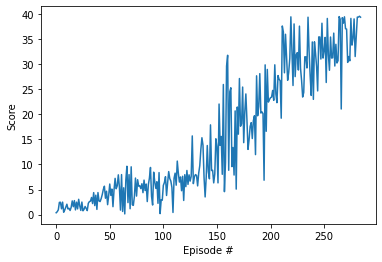

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(history)), history)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Test the trained Agent

In [15]:
policy = PolicyNN(state_size, action_size)
policy.load_state_dict(torch.load('ppo-solved.pth'))

In [16]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment (train_mode=False shows an agent in action)
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions, _, _ = policy(states)                     # select an action (for each agent)
    env_info = env.step(actions.cpu().detach().numpy())[brain_name]          # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
    
print("Score: {:.2f}".format(np.mean(scores)))         # print the score (of a single agent)

Score: 38.99


In [17]:
env.close()